# Early Data Analysis
Interpreting data from `batch_analyse.py`. The aim is to filter out the dataset to the required properties to explore potential exocomet-type transits.

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import glob
import data
import os
from astropy.table import Table, unique
from analysis_tools_cython import *
from post_processing_tools import *
from tqdm import tqdm

---

### Functions

---

## Creating DataFrame
- data initially used is `corrected flux`, not PCA.

In [3]:
df = get_output('output_s6_pca.txt')
filtered_df = filter_df(df)

In [4]:
df['transit_prob'].unique()

array(['end', 'maybeTransit', 'point', 'artefact'], dtype=object)

`filtered_df` with `maybeTransit` only

In [5]:
filtered_df[filtered_df.transit_prob == 'maybeTransit']

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
87,tesslc_358107514.pkl,-27.903934,-5.866886,1476.572388,1.182591,0.323369,0.101092,0.624990,-0.134743,maybeTransit
204,tesslc_349057825.pkl,-7.882467,-5.762652,1475.469482,1.021136,0.247970,0.067576,0.645841,-0.004414,maybeTransit
434,tesslc_48239010.pkl,-10.659525,-5.312474,1476.265259,1.027393,0.368093,0.080954,0.687505,-0.007825,maybeTransit
627,tesslc_30925984.pkl,-15.159836,-6.173104,1476.264404,1.010733,0.306724,0.092356,0.645818,-0.019787,maybeTransit
1292,tesslc_282993844.pkl,-14.117113,-5.011908,1476.182617,1.017565,0.430078,0.117528,0.687510,-0.010641,maybeTransit
...,...,...,...,...,...,...,...,...,...,...
524743,tesslc_177308499.pkl,-10.370194,-5.018638,1475.843628,1.012073,0.611535,0.021303,1.000008,-0.007814,maybeTransit
524797,tesslc_391923591.pkl,-11.723639,-5.650151,1476.322632,1.034390,0.366412,0.024342,0.770840,-0.008272,maybeTransit
525389,tesslc_39170030.pkl,-23.484606,-5.036652,1476.599487,1.370841,0.453997,0.009624,0.708324,-0.046472,maybeTransit
525460,tesslc_391904410.pkl,-15.697235,-5.283535,1475.614502,1.009699,0.486335,0.086231,0.729174,-0.008704,maybeTransit


---

### Raw Plot

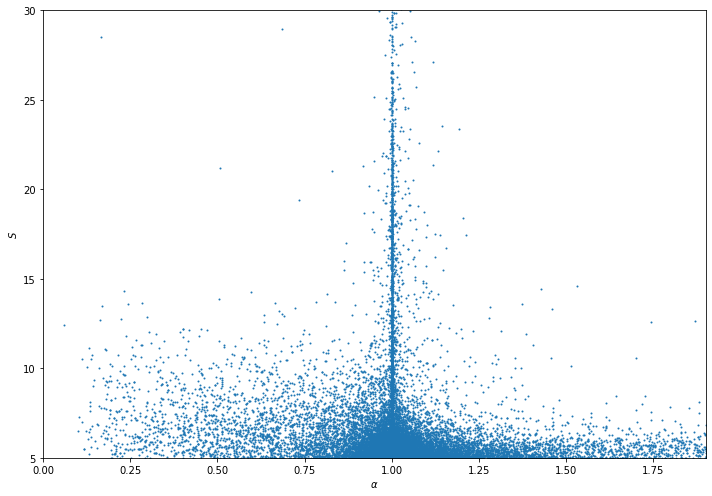

In [6]:
distribution(df.asym_score,abs(df['signal/noise']))

### `MaybeTransit` only

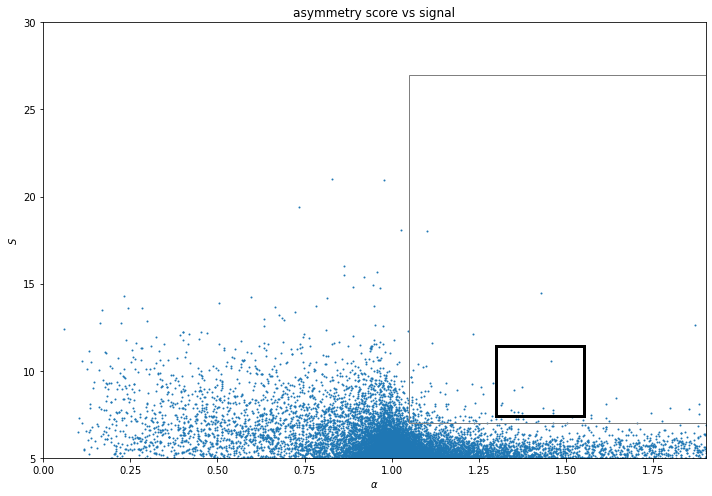

In [7]:
fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(df.asym_score[df.transit_prob == 'maybeTransit'],abs(df['signal/noise'][df.transit_prob == 'maybeTransit']),s=1)
ax.set_xlim(0,1.9)
ax.set_ylim(5,30)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$S$')
ax.set_title('asymmetry score vs signal')
fig.tight_layout()
rect = patches.Rectangle((1.30, 7.40), 0.25, 4, linewidth=3, edgecolor='k', facecolor='none')
interest_region = patches.Rectangle((1.05,7),3,20, linewidth=1,edgecolor='grey',facecolor='none') # region of interest in Kennedy et al
ax.add_patch(rect)
ax.add_patch(interest_region)
plt.show()

Next steps - apply a feature that distinguishes false positives, EB's, etc.

---

### Exploring that black boxed region (S6)

Create our box with the following settings:
- `signal/noise` between 7.4 and 12
- `asym_score` between 1.3 and 1.6

In [8]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.30) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]

In [9]:
to_import = box['file']
#example = box['file'].tail(25)

---

In [10]:
sector = 6
clip = 4
path = '/storage/astro2/phrdhx/tesslcs'
mad_df = data.load_mad()

#### Saving TIC paths

In [11]:
# for i in tqdm(to_import):
#     file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
#     ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
#     store = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=False)[1]
#     tic = store[0]
#     ra = store[1]
#     dec = store[2]
#     to_export = [tic,ra,dec]
#     with open("weird_tic_path.txt", "a") as output:
#         output.write(file_paths+'\n')

---

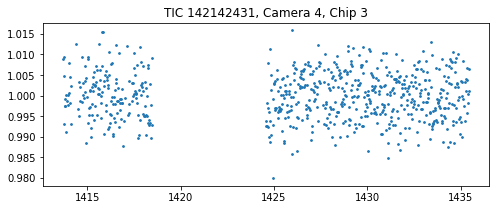

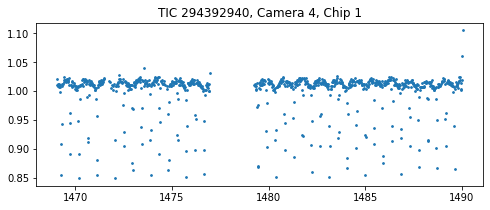

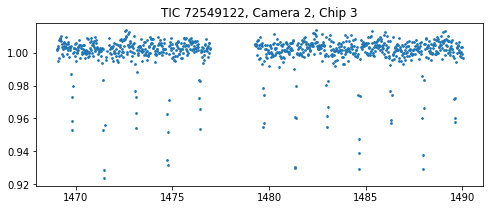

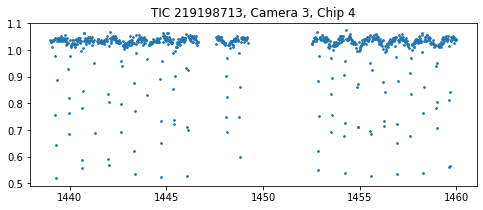

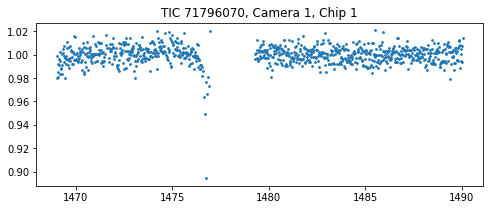

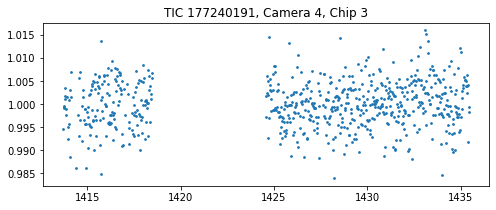

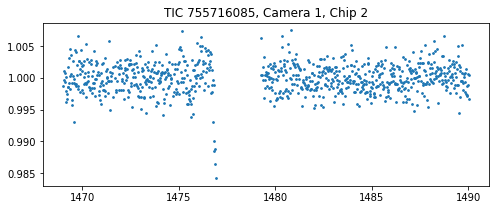

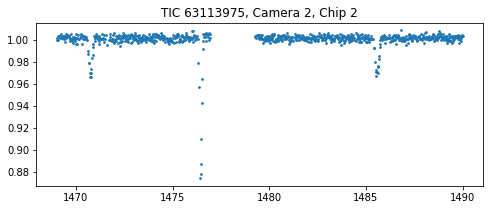

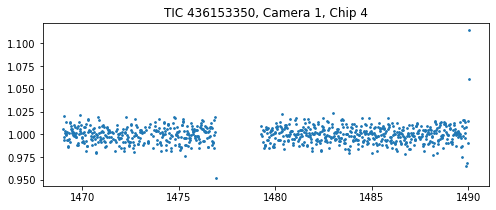

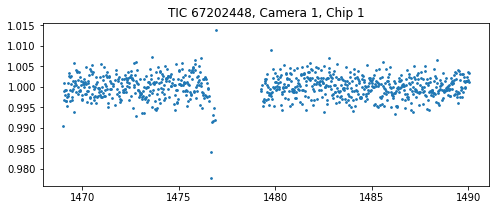

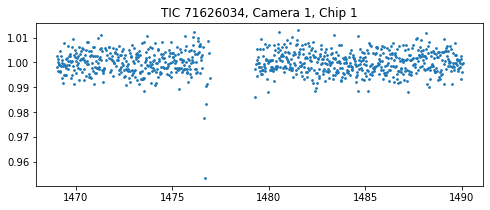

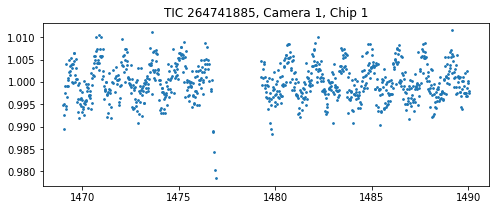

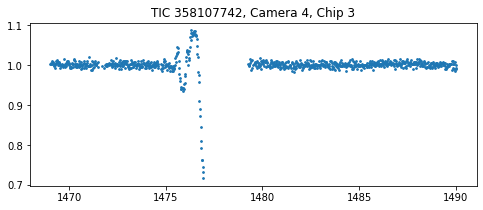

In [12]:
for i in to_import:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
    table,store = import_XRPlightcurve(file_paths,sector=sector,clip=4,drop_bad_points=True)
    camera = store[4]
    tic = store[0]
    chip = store[5]
    fig,ax = plt.subplots(1,figsize=(8,3))
    ax.set_title(f'TIC {tic}, Camera {camera}, Chip {chip}')
    ax.scatter(table['time'],normalise_lc(table['PCA flux']),s=3)
    plt.show()
    
#     mad_arr = mad_df.loc[:len(table['time'])-1,f"{sector}-{camera}"]
#     sig_clip = sigma_clip(mad_arr,sigma=clip,masked=True)
#     med_sig_clip = np.nanmedian(sig_clip)
#     rms_sig_clip = np.nanstd(sig_clip)
#     mad_cut = mad_arr.values < ~sig_clip.mask 
    

#     fig, ax = plt.subplots(2,2,figsize=(10,8))
#     ax[0,1].scatter(table['time'], mad_arr, s=2)
#     ax[0,1].axhline(np.nanmedian(mad_arr), c='r')
#     ax[0,0].scatter(range(0,len(table['time'])), mad_arr, s=2)
#     ax[0,0].axhline(np.nanmedian(mad_arr), c='r')
#     ax[0,0].axhline(med_sig_clip + clip*rms_sig_clip, c='r')
#     ax[0,0].set_title(f'S{sector}-C{camera}')
#     plt.show()